In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# Connexion PostgreSQL
PG_HOST = os.getenv("PG_HOST", "localhost")
PG_PORT = int(os.getenv("PG_PORT", "5432"))
PG_DB   = os.getenv("PG_DB",   "bigdata")
PG_USER = os.getenv("PG_USER", "postgres")
PG_PASS = os.getenv("PG_PASS", "postgres")

ENGINE = create_engine(f"postgresql+psycopg2://{PG_USER}:{PG_PASS}@{PG_HOST}:{PG_PORT}/{PG_DB}")

def read_sql(q: str, **params) -> pd.DataFrame:
    """Helper pour exécuter une requête SQL et récupérer un DataFrame."""
    with ENGINE.connect() as conn:
        return pd.read_sql(text(q), conn, params=params)

print("Connected config:", {"host": PG_HOST, "port": PG_PORT, "db": PG_DB, "user": PG_USER})

Connected config: {'host': 'localhost', 'port': 5432, 'db': 'bigdata', 'user': 'postgres'}


## 1) Vérifications rapides

In [21]:
# Lister les tables du schéma dwh
tables = read_sql("""
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'dwh'
ORDER BY table_name;
""")
tables

,table_name
0,dim_datetime
1,dim_location
2,dim_payment_type
3,dim_rate_code
4,dim_vendor
5,fact_trip


In [22]:
# Comptage lignes par table
counts = read_sql("""
SELECT 'fact_trip' AS table, COUNT(*)::bigint AS count FROM dwh.fact_trip
UNION ALL
SELECT 'dim_datetime', COUNT(*)::bigint FROM dwh.dim_datetime
UNION ALL
SELECT 'dim_payment_type', COUNT(*)::bigint FROM dwh.dim_payment_type
UNION ALL
SELECT 'dim_rate_code', COUNT(*)::bigint FROM dwh.dim_rate_code
UNION ALL
SELECT 'dim_vendor', COUNT(*)::bigint FROM dwh.dim_vendor
UNION ALL
SELECT 'dim_location', COUNT(*)::bigint FROM dwh.dim_location
ORDER BY count DESC;
""")
counts

,table,count
0,fact_trip,2815614
1,dim_datetime,1983251
2,dim_location,262
3,dim_rate_code,7
4,dim_payment_type,6
5,dim_vendor,2


In [23]:
# Bornes temporelles dans la fact
timerange = read_sql("""
SELECT 
  MIN(pickup.ts)  AS min_pickup_ts,
  MAX(pickup.ts)  AS max_pickup_ts,
  MIN(dropoff.ts) AS min_dropoff_ts,
  MAX(dropoff.ts) AS max_dropoff_ts
FROM dwh.fact_trip f
JOIN dwh.dim_datetime pickup  ON pickup.datetime_key  = f.pickup_datetime_key
JOIN dwh.dim_datetime dropoff ON dropoff.datetime_key = f.dropoff_datetime_key;
""")
timerange

,min_pickup_ts,max_pickup_ts,min_dropoff_ts,max_dropoff_ts
0,2024-12-31 20:47:55,2025-02-01 00:00:44,2024-12-31 20:54:00,2025-02-01 23:44:11


## 2) Aperçu de données

In [24]:
sample = read_sql("""
SELECT
  pickup.ts  AS pickup_ts,
  dropoff.ts AS dropoff_ts,
  f.passenger_count,
  f.trip_distance,
  f.fare_amount,
  f.total_amount,
  f.tip_amount,
  pay.payment_type_id,
  ven.vendor_id,
  rc.rate_code_id,
  f.source_file
FROM dwh.fact_trip f
JOIN dwh.dim_datetime pickup  ON pickup.datetime_key  = f.pickup_datetime_key
JOIN dwh.dim_datetime dropoff ON dropoff.datetime_key = f.dropoff_datetime_key
JOIN dwh.dim_payment_type pay ON pay.payment_type_key = f.payment_type_key
JOIN dwh.dim_vendor ven       ON ven.vendor_key       = f.vendor_key
JOIN dwh.dim_rate_code rc     ON rc.rate_code_key     = f.rate_code_key
LIMIT 10;
""")
sample

,pickup_ts,dropoff_ts,passenger_count,trip_distance,fare_amount,total_amount,tip_amount,payment_type_id,vendor_id,rate_code_id,source_file
0,2025-01-01 00:38:39,2025-01-01 00:52:19,1,1.91,14.2,23.04,3.84,1,2,1,yellow_tripdata_2025-01.parquet
1,2025-01-01 00:38:39,2025-01-01 00:54:31,4,2.23,15.6,20.60,0.00,1,2,1,yellow_tripdata_2025-01.parquet
2,2025-01-01 00:38:39,2025-01-01 00:58:18,1,4.78,24.7,35.64,5.94,1,2,1,yellow_tripdata_2025-01.parquet
3,2025-01-01 00:46:47,2025-01-01 01:00:00,1,1.70,12.1,20.50,3.40,1,1,1,yellow_tripdata_2025-01.parquet
4,2025-01-01 00:46:47,2025-01-01 01:02:28,1,1.58,12.1,17.10,0.00,2,2,1,yellow_tripdata_2025-01.parquet
5,2025-01-01 00:46:47,2025-01-01 01:17:51,1,5.56,30.3,42.36,7.06,1,2,1,yellow_tripdata_2025-01.parquet
6,2025-01-01 00:16:23,2025-01-01 00:30:43,2,1.60,14.2,24.20,5.00,1,1,1,yellow_tripdata_2025-01.parquet
7,2025-01-01 00:16:23,2025-01-01 00:37:24,1,4.27,23.3,33.96,5.66,1,2,1,yellow_tripdata_2025-01.parquet
8,2025-01-01 00:16:23,2025-01-01 00:26:30,2,1.59,11.4,21.32,4.92,1,2,1,yellow_tripdata_2025-01.parquet
9,2025-01-01 00:21:07,2025-01-01 00:31:27,1,1.40,11.4,16.40,0.00,2,1,1,yellow_tripdata_2025-01.parquet


## 3) KPI globaux

In [25]:
kpis = read_sql("""
SELECT
  COUNT(*)::bigint AS n_trips,
  AVG(passenger_count)::numeric(10,2) AS avg_passengers,
  AVG(trip_distance)::numeric(10,2)   AS avg_distance,
  AVG(fare_amount)::numeric(10,2)     AS avg_fare,
  AVG(total_amount)::numeric(10,2)    AS avg_total,
  SUM(total_amount)::numeric(18,2)    AS sum_total,
  AVG(tip_amount)::numeric(10,2)      AS avg_tip,
  SUM(tip_amount)::numeric(18,2)      AS sum_tip
FROM dwh.fact_trip;
""")
kpis

,n_trips,avg_passengers,avg_distance,avg_fare,avg_total,sum_total,avg_tip,sum_tip
0,2815614,1.31,3.23,18.26,27.69,77960846.82,3.5,9855969.39


## 4) Analyse temporelle

In [26]:
daily = read_sql("""
SELECT
  DATE(pickup.ts) AS day,
  COUNT(*)::bigint AS trips,
  SUM(f.total_amount)::numeric(18,2) AS revenue,
  AVG(f.trip_distance)::numeric(10,2) AS avg_distance
FROM dwh.fact_trip f
JOIN dwh.dim_datetime pickup ON pickup.datetime_key = f.pickup_datetime_key
GROUP BY 1
ORDER BY 1;
""")

daily.head()

,day,trips,revenue,avg_distance
0,2024-12-31,21,589.17,3.66
1,2025-01-01,70353,2079770.18,3.94
2,2025-01-02,77542,2303567.51,3.74
3,2025-01-03,83756,2356526.23,3.43
4,2025-01-04,89264,2393836.42,3.28


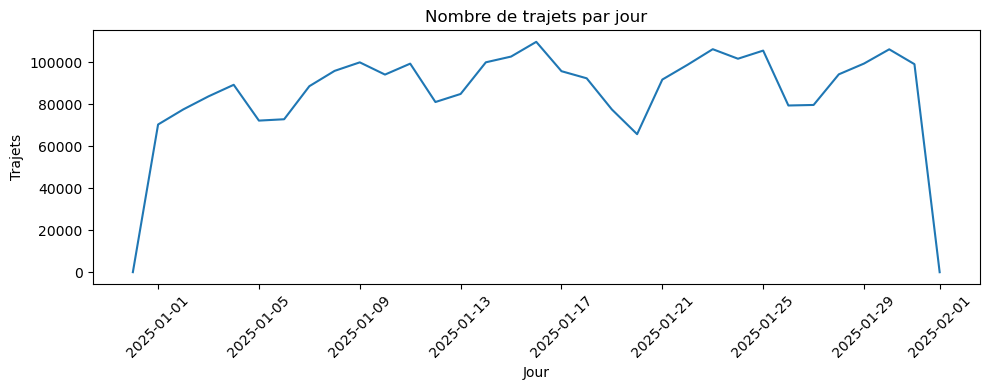

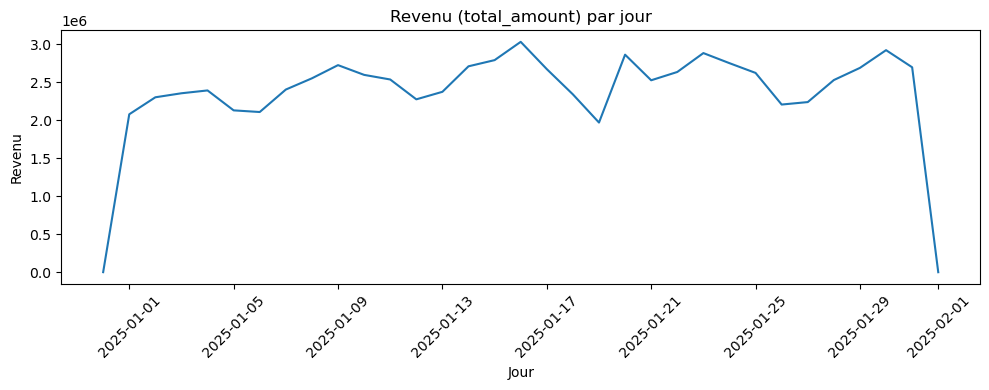

In [27]:
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily["day"]), daily["trips"])
plt.title("Nombre de trajets par jour")
plt.xlabel("Jour")
plt.ylabel("Trajets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily["day"]), daily["revenue"])
plt.title("Revenu (total_amount) par jour")
plt.xlabel("Jour")
plt.ylabel("Revenu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
hourly = read_sql("""
SELECT
  pickup.hour AS hour,
  COUNT(*)::bigint AS trips,
  AVG(f.total_amount)::numeric(10,2) AS avg_total
FROM dwh.fact_trip f
JOIN dwh.dim_datetime pickup ON pickup.datetime_key = f.pickup_datetime_key
GROUP BY 1
ORDER BY 1;
""")
hourly

,hour,trips,avg_total
0,0,65111,28.98
1,1,43674,26.28
2,2,29452,24.99
3,3,19147,26.11
4,4,12330,33.32
5,5,15376,37.60
6,6,34869,30.33
7,7,74110,26.99
8,8,105792,25.16
9,9,122168,25.45


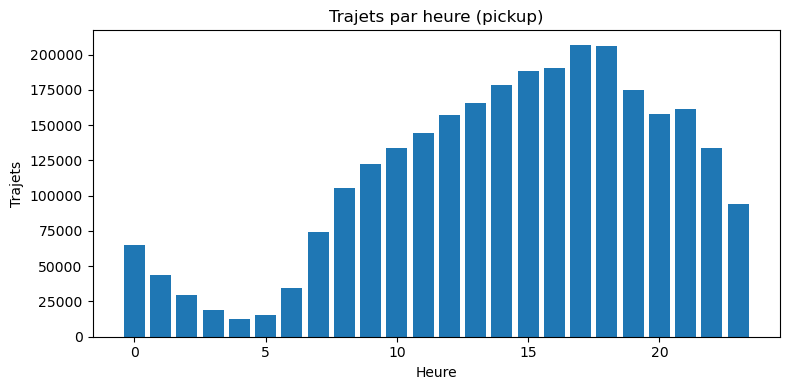

In [29]:
plt.figure(figsize=(8,4))
plt.bar(hourly["hour"], hourly["trips"])
plt.title("Trajets par heure (pickup)")
plt.xlabel("Heure")
plt.ylabel("Trajets")
plt.tight_layout()
plt.show()

In [30]:
# Note: on utilise
dow = read_sql("""
SELECT
  pickup.dow AS dow,
  COUNT(*)::bigint AS trips,
  AVG(f.total_amount)::numeric(10,2) AS avg_total
FROM dwh.fact_trip f
JOIN dwh.dim_datetime pickup ON pickup.datetime_key = f.pickup_datetime_key
GROUP BY 1
ORDER BY 1;
""")
dow

,dow,trips,avg_total
0,1,310189,27.68
1,2,303164,31.63
2,3,374603,27.16
3,4,467122,27.30
4,5,499610,27.77
5,6,474410,27.57
6,7,386516,25.61


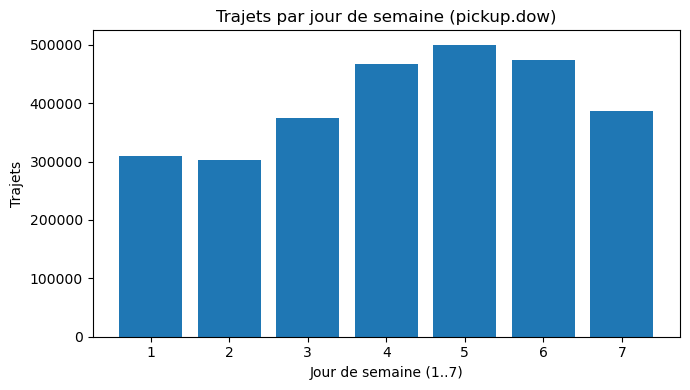

In [31]:
plt.figure(figsize=(7,4))
plt.bar(dow["dow"], dow["trips"])
plt.title("Trajets par jour de semaine (pickup.dow)")
plt.xlabel("Jour de semaine (1..7)")
plt.ylabel("Trajets")
plt.tight_layout()
plt.show()

## 5) Distributions (distance, total_amount, tip)

In [32]:
# Échantillon pour des histogrammes rapides
dist = read_sql("""
SELECT trip_distance, total_amount, tip_amount, passenger_count
FROM dwh.fact_trip
WHERE trip_distance IS NOT NULL AND total_amount IS NOT NULL
LIMIT 200000;
""")

dist.describe()

,trip_distance,total_amount,tip_amount,passenger_count
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,3.559503,28.107863,3.502002,1.447550
std,5.825066,23.331067,4.160540,0.869852
min,0.010000,1.460000,0.000000,1.000000
25%,1.000000,15.120000,1.000000,1.000000
50%,1.700000,19.900000,2.720000,1.000000
75%,3.400000,29.200000,4.210000,2.000000
max,1472.370000,607.010000,333.300000,8.000000


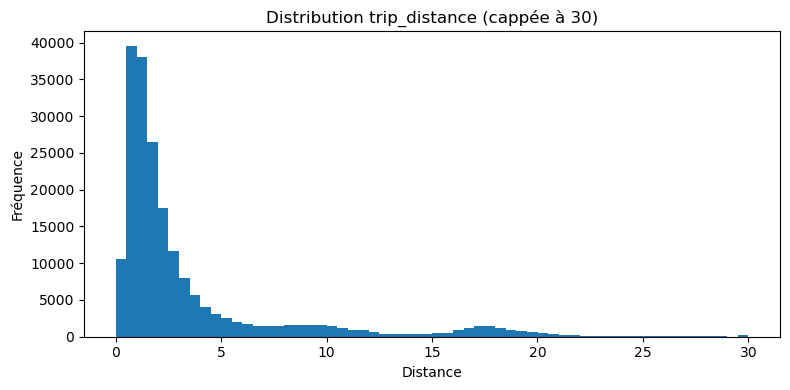

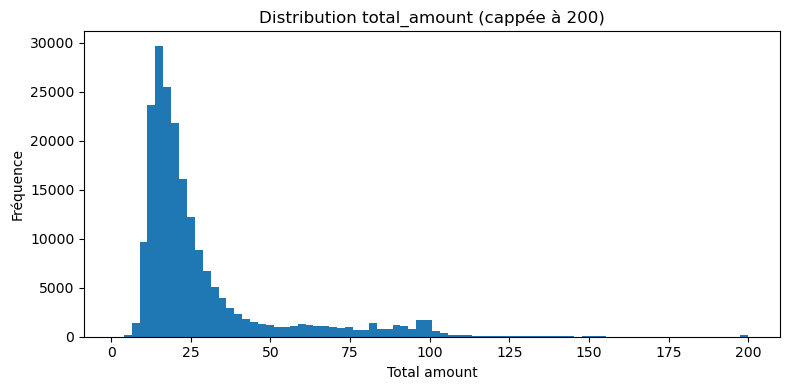

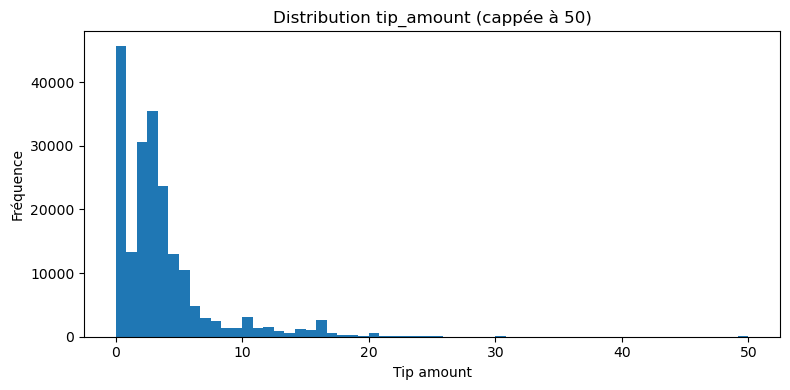

In [33]:
plt.figure(figsize=(8,4))
plt.hist(dist["trip_distance"].clip(upper=30), bins=60)
plt.title("Distribution trip_distance (cappée à 30)")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(dist["total_amount"].clip(upper=200), bins=80)
plt.title("Distribution total_amount (cappée à 200)")
plt.xlabel("Total amount")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(dist["tip_amount"].clip(upper=50), bins=60)
plt.title("Distribution tip_amount (cappée à 50)")
plt.xlabel("Tip amount")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

## 6) Analyse par dimensions (payment, vendor, rate code, locations)

In [34]:
payment = read_sql("""
SELECT
  pay.payment_type_id,
  COUNT(*)::bigint AS trips,
  AVG(f.total_amount)::numeric(10,2) AS avg_total,
  AVG(f.tip_amount)::numeric(10,2) AS avg_tip
FROM dwh.fact_trip f
JOIN dwh.dim_payment_type pay ON pay.payment_type_key = f.payment_type_key
GROUP BY 1
ORDER BY trips DESC;
""")
payment

,payment_type_id,trips,avg_total,avg_tip
0,1,2404258,27.96,4.10
1,2,364129,23.66,0.00
2,4,35469,51.99,0.01
3,3,11758,24.32,0.00


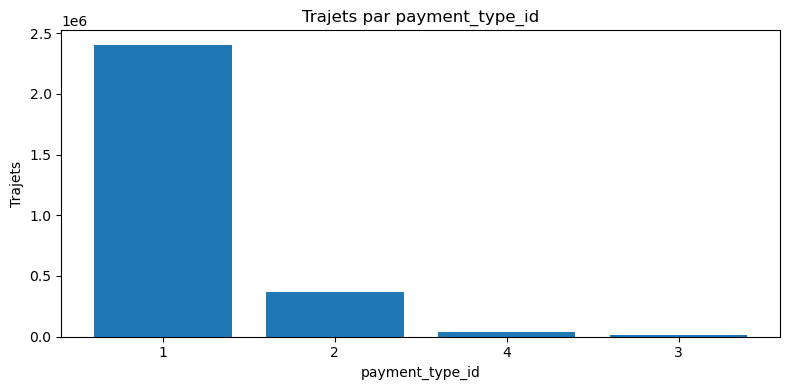

In [35]:
plt.figure(figsize=(8,4))
plt.bar(payment["payment_type_id"].astype(str), payment["trips"])
plt.title("Trajets par payment_type_id")
plt.xlabel("payment_type_id")
plt.ylabel("Trajets")
plt.tight_layout()
plt.show()

In [36]:
vendor = read_sql("""
SELECT
  ven.vendor_id,
  COUNT(*)::bigint AS trips,
  AVG(f.total_amount)::numeric(10,2) AS avg_total
FROM dwh.fact_trip f
JOIN dwh.dim_vendor ven ON ven.vendor_key = f.vendor_key
GROUP BY 1
ORDER BY trips DESC;
""")
vendor

,vendor_id,trips,avg_total
0,2,2187074,27.78
1,1,628540,27.38


In [37]:
rate = read_sql("""
SELECT
  rc.rate_code_id,
  COUNT(*)::bigint AS trips,
  AVG(f.total_amount)::numeric(10,2) AS avg_total
FROM dwh.fact_trip f
JOIN dwh.dim_rate_code rc ON rc.rate_code_key = f.rate_code_key
GROUP BY 1
ORDER BY trips DESC;
""")
rate

,rate_code_id,trips,avg_total
0,1,2659839,24.52
1,2,88092,93.97
2,99,39010,35.71
3,5,14678,91.89
4,3,7397,113.60
5,4,6591,133.46
6,6,7,4.89


In [38]:
top_pu = read_sql("""
SELECT loc.location_id, COUNT(*)::bigint AS trips
FROM dwh.fact_trip f
JOIN dwh.dim_location loc ON loc.location_key = f.pu_location_key
GROUP BY 1
ORDER BY trips DESC
LIMIT 15;
""")

top_do = read_sql("""
SELECT loc.location_id, COUNT(*)::bigint AS trips
FROM dwh.fact_trip f
JOIN dwh.dim_location loc ON loc.location_key = f.do_location_key
GROUP BY 1
ORDER BY trips DESC
LIMIT 15;
""")

top_pu, top_do

(    location_id   trips
 0           237  148003
 1           161  146750
 2           236  137810
 3           132  133722
 4           186  108175
 5           230  107524
 6           162  105056
 7           142   97557
 8           138   85429
 9           163   84648
 10          239   81826
 11          170   79497
 12          234   78003
 13           68   75273
 14           48   70211,
     location_id   trips
 0           236  144476
 1           237  133560
 2           161  111895
 3           230   89103
 4           142   85342
 5           239   84955
 6           170   82651
 7           141   80319
 8           162   79603
 9           163   72780
 10           68   71818
 11          234   69750
 12          238   68090
 13           48   66559
 14          140   63076)

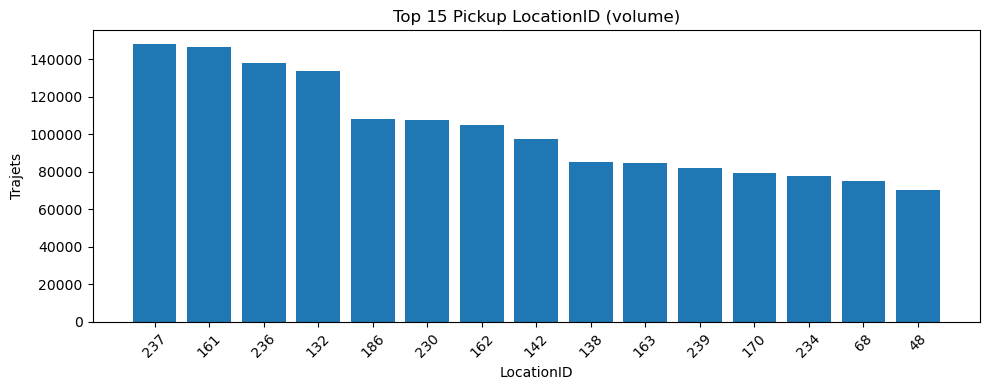

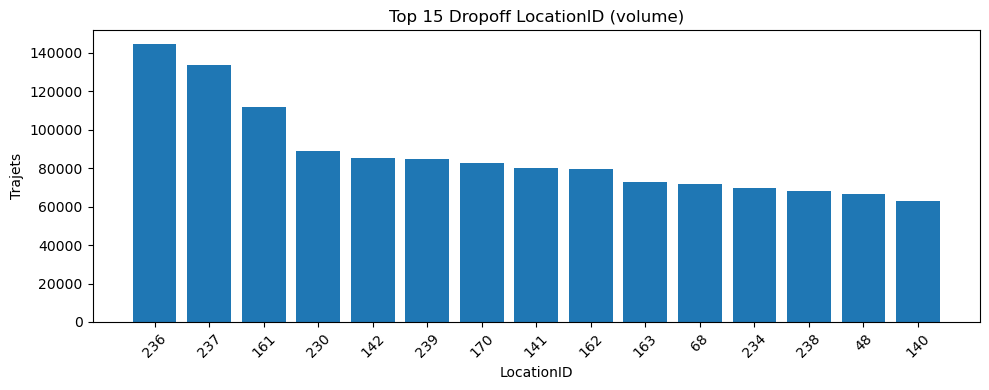

In [39]:
plt.figure(figsize=(10,4))
plt.bar(top_pu["location_id"].astype(str), top_pu["trips"])
plt.title("Top 15 Pickup LocationID (volume)")
plt.xlabel("LocationID")
plt.ylabel("Trajets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(top_do["location_id"].astype(str), top_do["trips"])
plt.title("Top 15 Dropoff LocationID (volume)")
plt.xlabel("LocationID")
plt.ylabel("Trajets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7) Heatmap: heure × jour de semaine

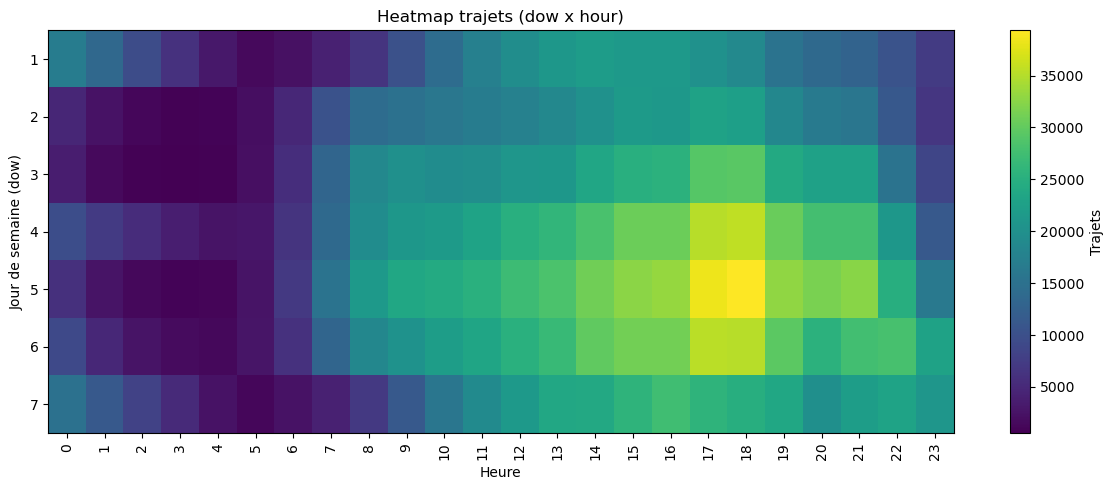

In [40]:
hm = read_sql("""
SELECT
  pickup.dow AS dow,
  pickup.hour AS hour,
  COUNT(*)::bigint AS trips
FROM dwh.fact_trip f
JOIN dwh.dim_datetime pickup ON pickup.datetime_key = f.pickup_datetime_key
GROUP BY 1,2
ORDER BY 1,2;
""")

pivot = hm.pivot(index="dow", columns="hour", values="trips").fillna(0)

plt.figure(figsize=(12,5))
plt.imshow(pivot.values, aspect="auto")
plt.title("Heatmap trajets (dow x hour)")
plt.xlabel("Heure")
plt.ylabel("Jour de semaine (dow)")
plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns, rotation=90)
plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
plt.colorbar(label="Trajets")
plt.tight_layout()
plt.show()